# Fixed-X knockoffs

This tutorial generates fixed-X knockoffs and checks some of its basic properties. The methodology is described in the following paper

> Barber, Rina Foygel, and Emmanuel J. Candès. "Controlling the false discovery rate via knockoffs." The Annals of Statistics 43.5 (2015): 2055-2085.


!!! note
    For fixed-X knockoffs, we assume $n > 2p$ where $n$ is sample size and $p$ is number of covariates, although in principle this method can be adapted to work for $n > p$ case.

In [60]:
# load packages needed for this tutorial
using Knockoffs
using Random
using GLMNet
using LinearAlgebra
using Distributions
using Plots
gr(fmt=:png);

## Generate knockoffs

We will

1. Simulate Gaussian design matrix
2. Generate knockoffs. Here we generate maximum entropy (ME) knockoffs as described in [this paper](https://arxiv.org/abs/2011.14625). ME knockoffs tend to have higher power over SDP or equi-correlated knockoffs. For more options, see the [fixed_knockoffs API](https://biona001.github.io/Knockoffs.jl/dev/man/api/#Knockoffs.fixed_knockoffs).

In [61]:
X = randn(1000, 200) # simulate Gaussian matrix
normalize_col!(X)    # normalize columns of X

# make ME knockoffs
@time me = fixed_knockoffs(X, :maxent);

  0.767067 seconds (102 allocations: 22.303 MiB)


The return type is a `Knockoff` struct, which contains the following fields

```julia
struct GaussianKnockoff{T<:AbstractFloat, M<:AbstractMatrix, S <: Symmetric} <: Knockoff
    X::M # n × p design matrix
    Xko::Matrix{T} # n × mp knockoff of X
    s::Vector{T} # p × 1 vector. Diagonal(s) and 2Sigma - Diagonal(s) are both psd
    Sigma::S # p × p symmetric covariance matrix. 
    method::Symbol # method for solving s
    m::Int # number of knockoffs per feature generated
end
```

Thus, to access these fields, one can do

In [62]:
Xko = me.Xko      
s = me.s
Sigma = me.Sigma; # estimated covariance matrix

We can check some knockoff properties. For instance, is it true that $X'\tilde{X} \approx \Sigma - diag(s)$?

In [63]:
# compare X'Xko and Sigma-diag(s) visually
[vec(X'*Xko) vec(Sigma - Diagonal(s))]

40000×2 Matrix{Float64}:
  0.376926     0.376926
 -0.0434507   -0.0434507
 -0.00211772  -0.00211772
 -0.00720163  -0.00720163
 -0.0160462   -0.0160462
  0.00304937   0.00304937
 -0.0207398   -0.0207398
 -0.0171064   -0.0171064
  0.0164143    0.0164143
 -0.0314399   -0.0314399
 -0.01243     -0.01243
  0.0308754    0.0308754
  0.0194948    0.0194948
  ⋮           
 -0.0183637   -0.0183637
  0.0180358    0.0180358
 -0.0269833   -0.0269833
  0.00231273   0.00231273
  0.0047828    0.0047828
  0.0191073    0.0191073
  0.0116001    0.0116001
 -0.0203994   -0.0203994
  0.00449654   0.00449654
 -0.00696245  -0.00696245
 -0.0045149   -0.0045149
  0.363215     0.363215

## LASSO example

Let us apply the generated knockoffs to the model selection problem

> Given response $\mathbf{y}_{n \times 1}$, design matrix $\mathbf{X}_{n \times p}$, we want to select a subset $S \subset \{1,...,p\}$ of variables that are truly causal for $\mathbf{y}$. 

### Simulate data

We will simulate 

$$\mathbf{y}_{n \times 1} \sim N(\mathbf{X}_{n \times p}\mathbf{\beta}_{p \times 1} \ , \ \mathbf{\epsilon}_{n \times 1}), \quad \epsilon_i \sim N(0, 0.5)$$

where $k=50$ positions of $\mathbf{\beta}$ is non-zero with effect size $\beta_j \sim N(0, 1)$. The goal is to recover those 50 positions using LASSO.

In [74]:
# set seed for reproducibility
Random.seed!(2022)

# simulate true beta
n, p = size(X)
k = 50
βtrue = zeros(p)
βtrue[1:k] .= randn(50)
shuffle!(βtrue)

# find true causal variables
correct_position = findall(!iszero, βtrue)

# simulate y using normalized X
y = X * βtrue + randn(n)

1000-element Vector{Float64}:
  11.443750905602776
   0.9838821881590077
   4.005284705393306
  -3.7700161069515
 -13.00069065413081
  -3.723567487544001
  -0.023706041074809142
  -7.7754509432906405
  -1.3428086906548775
   2.997872505761214
   3.0159247260525435
   7.447226561613222
   0.8552180712448658
   ⋮
   7.5361496693874495
   4.931186951450571
  -2.257175596026274
  -0.5319905325018484
   8.025043090281391
   6.3728542780832385
  -3.0432136216197696
   0.77378700225668
  -3.454973406104122
  -5.29163844545535
   2.74314096421341
   0.05144992498465495

### Standard LASSO

Lets try running standard LASSO, which will produce $\hat{\mathbf{\beta}}_{p \times 1}$ where we typically declare variable $j$ to be selected if $\hat{\beta}_j \ne 0$. We use LASSO solver in [GLMNet.jl](https://github.com/JuliaStats/GLMNet.jl) package, which is just a Julia wrapper for the GLMnet Fortran code. 

How well does LASSO perform in terms of power and FDR?

In [75]:
# run 10-fold cross validation to find best λ minimizing MSE
lasso_cv = glmnetcv(X, y)
λbest = lasso_cv.lambda[argmin(lasso_cv.meanloss)]

# use λbest to fit LASSO on full data
βlasso = glmnet(X, y, lambda=[λbest]).betas[:, 1]

# check power and false discovery rate
power = length(findall(!iszero, βlasso) ∩ correct_position) / k
FDR = length(setdiff(findall(!iszero, βlasso), correct_position)) / count(!iszero, βlasso)
println("Lasso power = $power, FDR = $FDR")

Lasso power = 0.96, FDR = 0.5


About half of all discoveries from Lasso regression are false positives. 

### Knockoff+LASSO

Now lets try applying the knockoff methodology. Recall that consists of a few steps 

1. Run LASSO on $[\mathbf{X} \mathbf{\tilde{X}}]$
2. Compare feature importance score $W_j = \text{score}(x_j) - \text{score}(\tilde{x}_j)$ for each $j = 1,...,p$. Here we use $W_j = |\beta_j| - |\tilde{\beta}_{j}|$
3. Choose target FDR $q \in [0, 1]$ and compute 
$$\tau = min_{t}\left\{t > 0: \frac{{\{\#j: W_j ≤ -t}\}}{max(1, {\{\#j: W_j ≥ t}\})} \le q\right\}$$

In [66]:
@time knockoff_filter = fit_lasso(y, me);

  1.049388 seconds (835 allocations: 46.274 MiB)


The return type is now a `LassoKnockoffFilter`, which contains the following information

```julia
struct LassoKnockoffFilter{T} <: KnockoffFilter
    y :: Vector{T} # n × 1 response vector
    X :: Matrix{T} # n × p matrix of original features
    ko :: Knockoff # A knockoff struct
    m :: Int # number of knockoffs per feature generated
    betas :: Vector{Vector{T}} # betas[i] is the p × 1 vector of effect sizes corresponding to fdr level fdr_target[i]
    a0 :: Vector{T}   # intercepts for each model in betas
    selected :: Vector{Vector{Int}} # selected[i] includes all variables selected based on target FDR level fdr_target[i]
    W :: Vector{T} # length p vector of feature importance
    taus :: Vector{T} # threshold for significance. For fdr fdr_target[i], tau[i] is threshold, and all W ≥ tau[i] is selected
    fdr_target :: Vector{T} # target FDR level for each taus and betas
    d :: UnivariateDistribution # distribution of y
    debias :: Union{Nothing, Symbol} # how betas and a0 have been debiased (`nothing` for not debiased)
end
```

Given these information, we can e.g. visualize power and FDR trade-off:

  0.730351 seconds (102 allocations: 22.303 MiB, 0.75% gc time)
  0.882967 seconds (835 allocations: 46.349 MiB)
  0.508460 seconds (102 allocations: 22.303 MiB)
  0.888551 seconds (835 allocations: 46.278 MiB)
  0.643473 seconds (102 allocations: 22.303 MiB)
  0.891910 seconds (835 allocations: 46.492 MiB, 0.18% gc time)
  0.432557 seconds (102 allocations: 22.303 MiB)
  0.859462 seconds (835 allocations: 46.205 MiB)
  0.474027 seconds (102 allocations: 22.303 MiB)
  0.879261 seconds (835 allocations: 46.277 MiB)
  0.586823 seconds (102 allocations: 22.303 MiB, 0.48% gc time)
  0.883496 seconds (835 allocations: 46.421 MiB)
  0.742627 seconds (102 allocations: 22.303 MiB)
  0.878495 seconds (835 allocations: 46.127 MiB)
  0.576416 seconds (102 allocations: 22.303 MiB)
  0.884102 seconds (835 allocations: 46.204 MiB, 0.15% gc time)
  0.617052 seconds (102 allocations: 22.303 MiB)
  0.885246 seconds (835 allocations: 46.493 MiB)
  0.536176 seconds (102 allocations: 22.303 MiB)
  0.87270

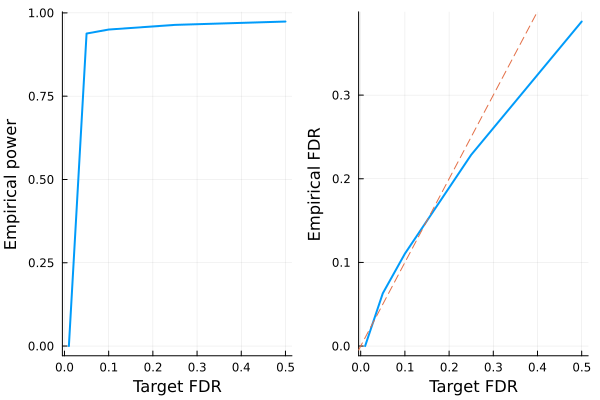

In [73]:
# run 10 simulations and compute empirical power/FDR
nsims = 10
empirical_power = zeros(5)
empirical_fdr = zeros(5)
for i in 1:nsims
    # simulate data
    X = randn(1000, 200)
    k = 50
    βtrue = zeros(p)
    βtrue[1:k] .= randn(50)
    shuffle!(βtrue)
    correct_position = findall(!iszero, βtrue)
    y = X * βtrue + randn(n)

    # generate knockoff and fit lasso
    @time me = fixed_knockoffs(X, :maxent)
    @time knockoff_filter = fit_lasso(y, me)

    # compute FDR/power
    FDR = knockoff_filter.fdr_target
    for i in eachindex(FDR)
        selected = knockoff_filter.selected[i]
        power = length(selected ∩ correct_position) / k
        fdp = length(setdiff(selected, correct_position)) / max(length(selected), 1)
        empirical_power[i] += power
        empirical_fdr[i] += fdp
    end
end
empirical_power ./= nsims
empirical_fdr ./= nsims

# visualize FDR and power
power_plot = plot(FDR, empirical_power, xlabel="Target FDR", ylabel="Empirical power", legend=false, w=2)
fdr_plot = plot(FDR, empirical_fdr, xlabel="Target FDR", ylabel="Empirical FDR", legend=false, w=2)
Plots.abline!(fdr_plot, 1, 0, line=:dash)
plot(power_plot, fdr_plot)

**Conclusion:** 

+ Regular Lasso has good power but nearly 50% of all discoveries are false positives. 
+ Knockoffs + Lasso controls the false discovery rate at below the target (dashed line)